Error máximo: 2.70447e-01
Máxima compresión (k=2500, λ=750): -0.16998
Máxima compresión (k=5000, λ=750): -0.16502
Máxima compresión (k=10000, λ=750): -0.15537
Máxima compresión (k=15000, λ=750): -0.18652
Máxima compresión (k=40000, λ=750): -0.24423


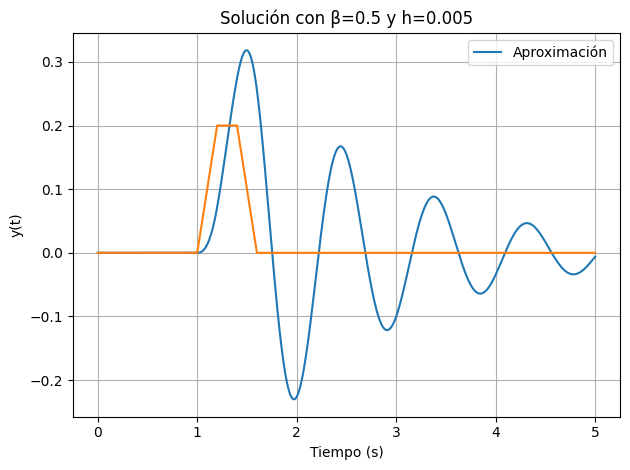

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Parámetros del sistema
padron = 109932
m = padron / 200
k = 25000
l_inicial = 750
c_inicial = 0.1
t_final = 5
h = 0.005
beta = 0.5

# Función de excitación externa c(t)
def c(t):
    if 1 <= t < 1.2:
        return t - 1.0
    elif 1.2 <= t < 1.4:
        return 0.2
    elif 1.4 <= t < 1.6:
        return 1.6 - t
    return 0.0

# Derivada de c(t)
def c_prima(t):
    if 1 <= t < 1.2:
        return 1.0
    elif 1.4 <= t < 1.6:
        return -1.0
    return 0.0

# Función del sistema amortiguado
def f(y, v, t, l, k):
    return ((k / m) * (c(t) - y)) + ((l / m) * (c_prima(t) - v))
    

# Cálculo de la matriz inversa para el sistema Ax = b
def calcular_A_inversa(beta, h, l, k):
    divisor = m + (h ** 2) * k * (beta ** 2) + h * beta * l
    return np.array([
        [(m + h * beta * l) / divisor, h * m * beta / divisor],
        [-h * k * beta / divisor, m / divisor]
    ])

# Término independiente del sistema
def calcular_termino_indep(beta, f, u, v, t, l, k):
    return np.array([
        h * (1 - beta) * v,
        h * beta * (k * (c(t)/m) +  l * (c_prima(t)/m)) + h * (1 - beta) * f(u, v, t, l, k)
    ])

# Método de integración numérica (implícito y explícito)
def metodo_ponderado_implicito(beta, h, f, t, l, k):
    u = np.zeros_like(t)
    v = np.zeros_like(t)
    uv_n = np.array([u[0], v[0]])
    A_inversa = calcular_A_inversa(beta, h, l, k)

    for n in range(len(t) - 1):
        termino_indep = calcular_termino_indep(beta, f, u[n], v[n], t[n], l, k)
        uv_np1 = A_inversa @ (uv_n + termino_indep)
        u[n + 1], v[n + 1] = uv_np1
        uv_n = uv_np1

    return u, v, t

# Período promedio de oscilación
def obtener_periodo_promedio(aproximacion, t):
    picos, _ = find_peaks(aproximacion)
    tiempos = t[picos]
    T = np.diff(tiempos)
    return np.mean(T)

# Graficar solución y errores
def graficar_resultados(t, u, beta, h, error_maximo=None):
#     fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax: plt.Axes
    fig, ax = plt.subplots()

    # Solución y analítica
    ax.plot(t, u, label="Aproximación")
#     ax.plot(t, sol_analitica(t), "r--", label="Solución Analítica")
    ax.plot(t, [c(paso) for paso in t])
    ax.set_title(f"Solución con β={beta} y h={h}")
    ax.set_xlabel("Tiempo (s)")
    ax.set_ylabel("y(t)")
    ax.legend()
    ax.grid()

    # Error
#     errores = sol_analitica(t) - u
#     ax[1].plot(t, errores, label="Error")
#     ax[1].set_title("Error en la Aproximación")
#     ax[1].set_xlabel("Tiempo (s)")
#     ax[1].set_ylabel("Error")
#     ax[1].grid()

    if error_maximo is not None:
        print(f"Error máximo: {error_maximo:.5e}")
    plt.tight_layout()
#     plt.show()

# Solución analítica de referencia
def sol_analitica(t):
    return 0.1 - 0.1 * np.cos(np.sqrt(k / m) * t)

# Evaluar compresión del sistema
def evaluar_compresion(beta, h, f, l, k):
    t = np.arange(0, t_final + h, h)
    u, v, t = metodo_ponderado_implicito(beta, h, f, t, l, k)
    aproximacion = u - np.array([c(ti) for ti in t])
    minima_compresion = np.min(aproximacion)
    print(f"Máxima compresión (k={k}, λ={l}): {minima_compresion:.5f}")

# Main
if __name__ == "__main__":
    l = 750
    t = np.arange(0, t_final + h, h)

    # Solución y análisis
    u, v, t = metodo_ponderado_implicito(beta, h, f, t, l, k)
    error_maximo = np.max(np.abs(sol_analitica(t) - u))
    graficar_resultados(t, u, beta, h, error_maximo)

    # Variar parámetros para análisis de compresión
    for k_test in [2500, 5000, 10000, 15000, 40000]:
        evaluar_compresion(beta, h, f, l, k_test)



